In [315]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import heavytools as hv
import pandas as pd
from matplotlib.patches import Rectangle

In [316]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [603]:
model_dirs = ["pls", "linear_l1_svm", "pls_boosting", "pooled_nn"]

fcms = {
    n:np.load(open(f"out/functional_connectivity/{n}/fcms.npy", "rb")) for n in model_dirs
}

fcms

{'pls': array([[[0.00000000e+00, 6.69120936e-04, 5.14179716e-04, ...,
          6.89426239e-05, 7.16973914e-05, 8.14724592e-05],
         [6.69120936e-04, 0.00000000e+00, 1.32334345e-04, ...,
          4.42288192e-04, 4.54636704e-04, 3.75310714e-04],
         [5.14179716e-04, 1.32334345e-04, 0.00000000e+00, ...,
          4.42777647e-04, 2.56519636e-05, 4.28377458e-04],
         ...,
         [6.89426239e-05, 4.42288192e-04, 4.42777647e-04, ...,
          0.00000000e+00, 5.64871410e-05, 1.56924170e-04],
         [7.16973914e-05, 4.54636704e-04, 2.56519636e-05, ...,
          5.64871410e-05, 0.00000000e+00, 1.68684160e-05],
         [8.14724592e-05, 3.75310714e-04, 4.28377458e-04, ...,
          1.56924170e-04, 1.68684160e-05, 0.00000000e+00]],
 
        [[0.00000000e+00, 7.91930342e-04, 5.49333453e-04, ...,
          4.43520039e-05, 9.52265239e-05, 1.73900276e-04],
         [7.91930342e-04, 0.00000000e+00, 1.13622796e-04, ...,
          1.55318462e-04, 4.98136624e-04, 3.33257692e-04],


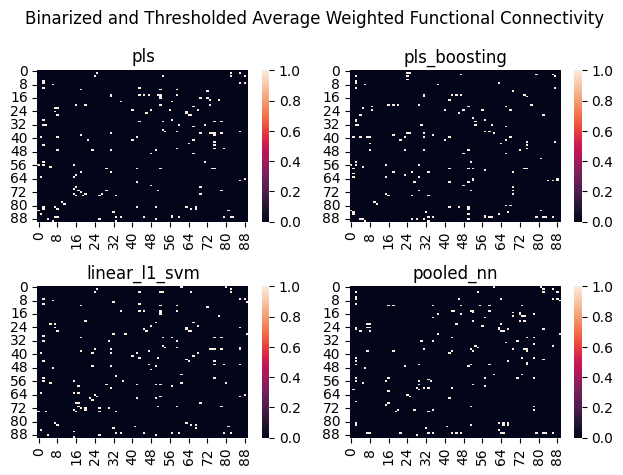

In [604]:
gab_fcms = {m:hv.binarize(hv.threshold(np.mean(v, axis=0))) for m, v in fcms.items()}

fig, ax = plt.subplots(2, 2)
for i, (name, gab_fcm) in enumerate(gab_fcms.items()):
    sns.heatmap(np.rot90(gab_fcm), ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)
    
fig.suptitle("Binarized and Thresholded Average Weighted Functional Connectivity")
fig.tight_layout()

In [605]:
import networkx as nx

In [606]:
def produce_graph(fcms):
    graph = nx.Graph()
    passed = set()
    for i in range(fcms.shape[0]):
        for j in range(fcms.shape[1]):
            if i == j:
                pass
        
            if fcms[i][j] > 0 and (j, i) not in passed:
                graph.add_edge(i, j)
                passed.add((i, j))
        
    return graph


In [607]:
graphs = {m:produce_graph(v) for m, v in gab_fcms.items()}

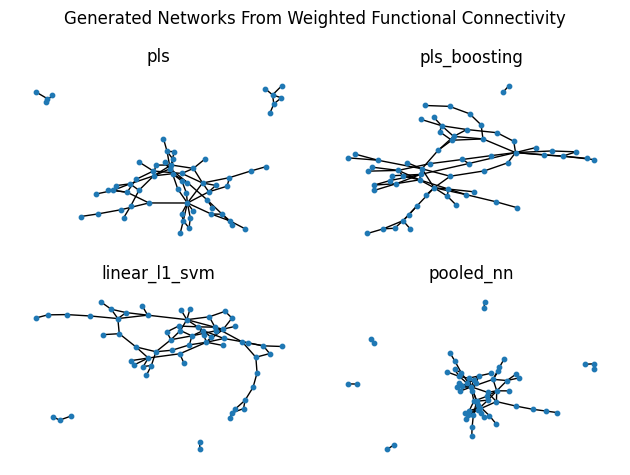

In [608]:
fig, ax = plt.subplots(2, 2)

for i, (name, graph) in enumerate(graphs.items()):
    nx.draw(graph, node_size=10, ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)

fig.suptitle("Generated Networks From Weighted Functional Connectivity")
fig.tight_layout()

In [609]:
import colorsys

def girvan_newman(graph, iters=1):
    gen = nx.algorithms.community.girvan_newman(graph)
    for _ in range(iters):
        graph = next(gen)
    
    return graph

def get_n_colors(n):
    HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    return RGB_tuples

def get_color_map(gn, graph):
    RGB_tuples = get_n_colors(len(gn))
    
    cmap = {}
    for i, d in enumerate(gn):
        for s in d:
            cmap[s] = RGB_tuples[i]

    cmap_arr = []
    for n in graph.nodes:
        cmap_arr.append(cmap[n] if n in cmap else (0, 0, 0))
    
    return cmap_arr, cmap



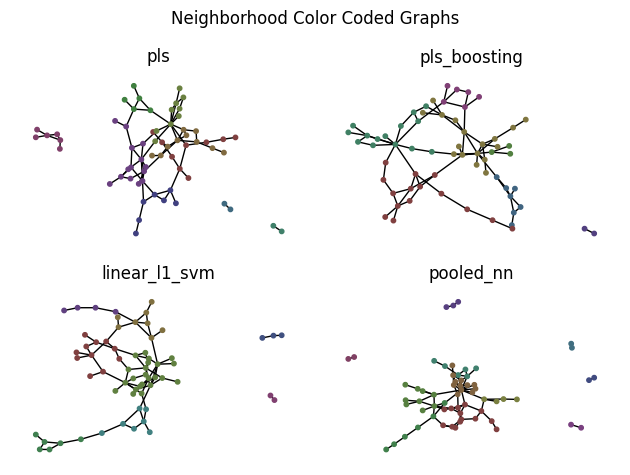

In [610]:
fig, ax = plt.subplots(2, 2)
gns = {}
gn_cmaps = {}

for i, (name, graph) in enumerate(graphs.items()):
    gn = girvan_newman(graph, iters=5)
    gn_cmap, gn_cmap_g = get_color_map(gn, graph)
    
    gns[name] = gn
    gn_cmaps[name] = (gn_cmap, gn_cmap_g)

    nx.draw(graph, node_size=10, node_color=gn_cmap, ax=ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)

fig.suptitle("Neighborhood Color Coded Graphs")
fig.tight_layout()

In [611]:
gns

{'pls': ({0, 1, 4, 6, 15, 19, 26, 33, 81},
  {7, 8, 23, 42, 46, 50, 63, 64, 65, 67},
  {2, 3, 35, 45, 57, 60, 71, 79, 83},
  {24, 25, 82, 86, 88},
  {5, 32},
  {10, 11},
  {16, 20, 27, 69, 72, 73, 77},
  {17, 18, 29, 31, 43, 47, 51, 52, 53, 54, 59, 74, 75, 78},
  {21, 40, 48, 56, 66, 68}),
 'linear_l1_svm': ({0, 3, 15, 16, 17, 20, 26, 30, 33, 36, 69},
  {1, 4, 22, 23, 29, 31, 42, 50},
  {2,
   18,
   24,
   25,
   35,
   43,
   45,
   47,
   51,
   52,
   53,
   54,
   57,
   59,
   60,
   73,
   74,
   75,
   78,
   79,
   82,
   86,
   88},
  {5, 32, 37, 61, 80, 89},
  {7, 8, 46, 63, 64, 65, 67},
  {6, 41, 81},
  {40, 48, 66, 68},
  {72, 77}),
 'pls_boosting': ({0, 6, 15, 16, 18, 20, 26, 29, 33, 35, 37, 51, 69, 77, 81},
  {1, 4, 7, 8, 23, 27, 28, 31, 42, 43, 45, 46, 50, 64, 72, 74, 75},
  {5, 32, 67},
  {2, 3, 30, 47, 53, 57, 59, 60, 63, 79, 82, 83, 86, 87},
  {9, 21, 40, 48, 56, 66, 68},
  {10, 11},
  {24, 25, 52, 61, 84, 88}),
 'pooled_nn': ({1, 18, 28, 29, 31, 43, 44, 51, 52, 59, 

In [612]:
def get_sorted_indices(graph, gn):
    sorted_indices = []
    remaining_idxes = list(range(90))
    
    for i, cluster in enumerate(gn):
        for node in cluster:
            sorted_indices.append(node)
            remaining_idxes.remove(node)
            
    return sorted_indices + remaining_idxes

def paint_neighbors(gn, ax):
    c = 0
    for i, n in enumerate(gn):
        ax.add_patch(Rectangle((c, 89-c), len(n), -len(n),
                     edgecolor = get_n_colors(len(gn))[i],
                     fill=False,
                     lw=1))
        c += len(n)

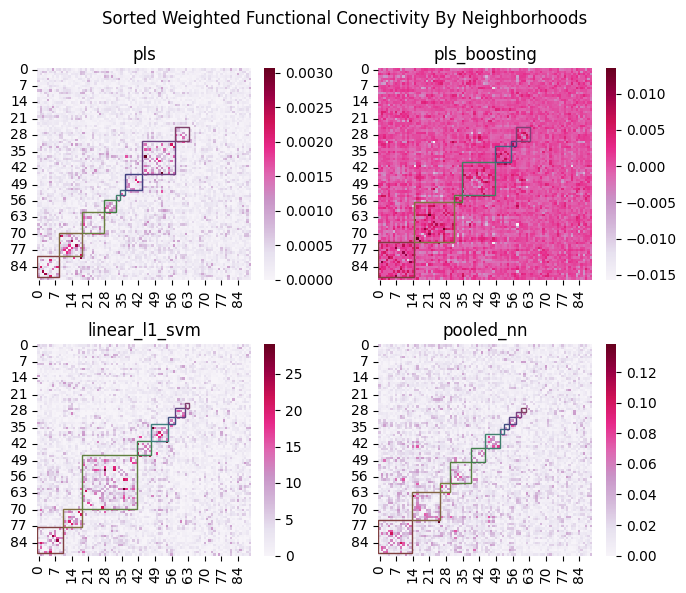

In [613]:
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

for i, (name, graph) in enumerate(graphs.items()):
    gn = gns[name]
    

    sorted_indices = get_sorted_indices(graph, gn)
    sns.heatmap(np.rot90(np.mean(fcms[name], axis=0)[sorted_indices][:, sorted_indices]), ax=ax[i%2, i//2], cmap="PuRd")

    paint_neighbors(gn, ax[i%2, i//2])
    ax[i%2, i//2].set(title=name)

fig.suptitle("Sorted Weighted Functional Conectivity By Neighborhoods")
fig.tight_layout()

In [617]:
selected_features = []
for g in np.array(gns["pls_boosting"])[np.argsort([len(g) for g in gns["pls_boosting"]], axis=0)[::-1]][:]:
    selected_features += g
selected_features = np.array(selected_features)
selected_features, selected_features.shape

(array([64,  1,  4,  7,  8, 72, 42, 74, 75, 43, 46, 45, 50, 23, 27, 28, 31,
         0, 33, 35, 69,  6, 37, 77, 15, 16, 81, 18, 51, 20, 26, 29,  2,  3,
        79, 47, 82, 83, 53, 86, 87, 57, 59, 60, 30, 63, 66, 68, 40,  9, 48,
        21, 56, 52, 84, 24, 25, 88, 61, 32, 67,  5, 10, 11]),
 (64,))

In [618]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import seaborn as sns
import utils as uu

In [619]:
splits_df = pd.read_csv('data/mj_splits_training_testing.csv')
labels    = np.repeat(np.array(splits_df['label']), 2)
training  = np.repeat(np.array(splits_df['training']), 2)
names     = np.repeat(np.array(splits_df['subject']), 2)

In [620]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [621]:
x_train, x_test = inputs[training == 1], inputs[training == 0]
y_train, y_test = labels[training == 1], labels[training == 0]

In [622]:
selected_features.shape

(64,)

In [623]:
x_train_select = np.array([hv.convert_triangle_to_mat(h) for h in x_train])[:, selected_features, :][:, :, selected_features]
x_test_select = np.array([hv.convert_triangle_to_mat(h) for h in x_test])[:, selected_features, :][:, :, selected_features]

x_train_select = np.array([uu.symm_mat_to_ut_vec(h) for h in x_train_select])
x_test_select = np.array([uu.symm_mat_to_ut_vec(h) for h in x_test_select])

In [624]:
from sklearn.calibration import CalibratedClassifierCV

class_weight = None#{0: 0.6, 1: 0.4}
# best hyperparameters: l1_svm: 0.02, l2_svm: 0.2, l1_logr: 0.01, l2_logr: 0.1

model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)

models = {"l1_logr":model_l1_logr, "l2_logr": model_l2_logr, "l1_svm":model_l1_svm, "l2_svm": model_l2_svm}

 Training model l2_logr, fold 6/10

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/_plotting.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


 Training model l2_svm, fold 9/100

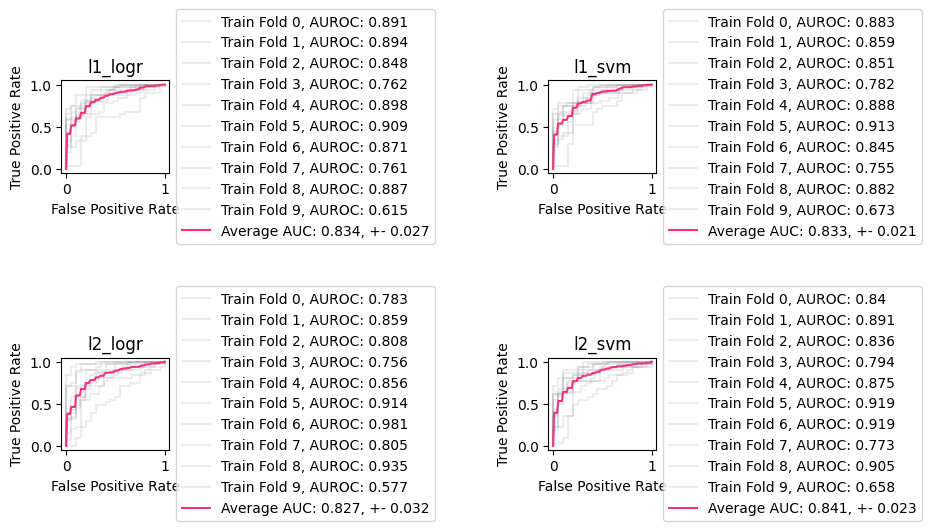

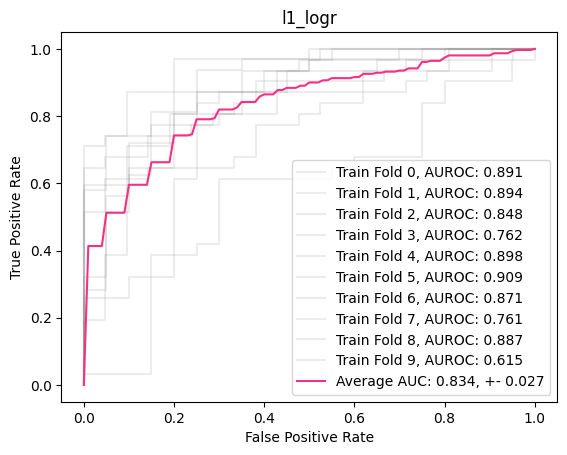

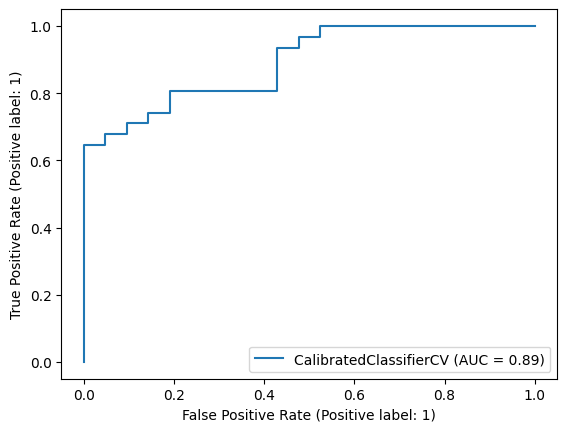

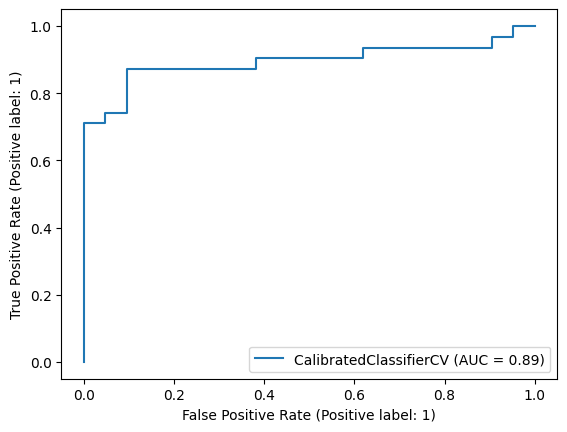

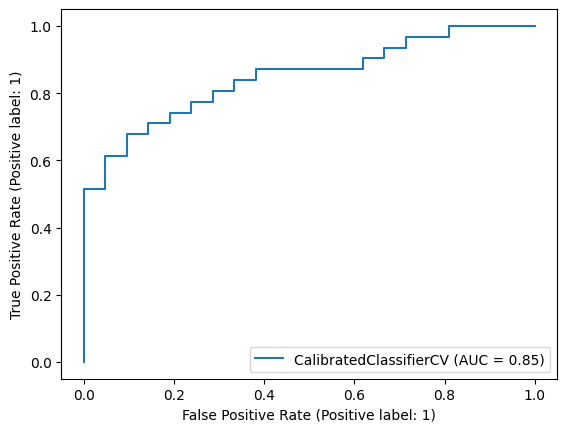

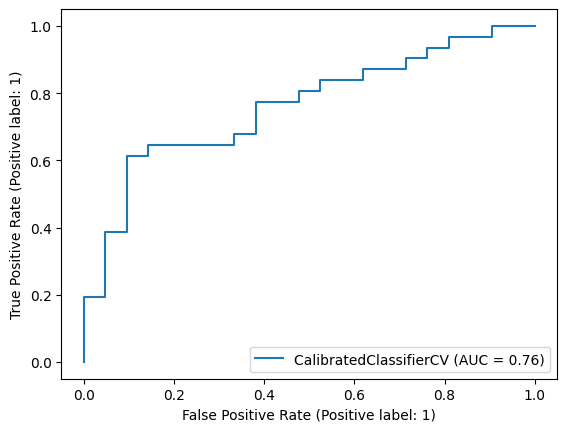

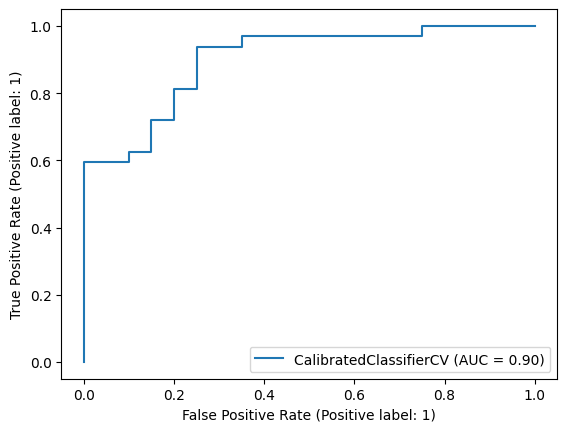

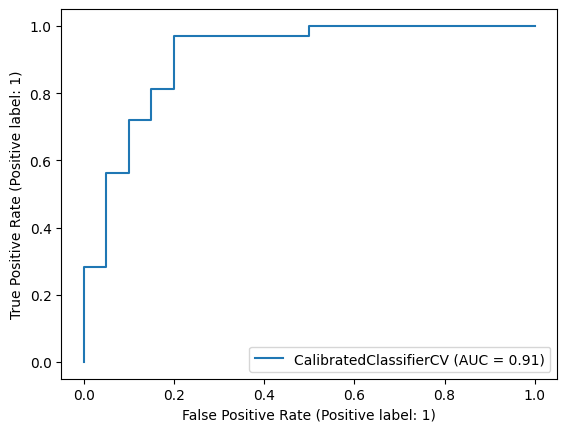

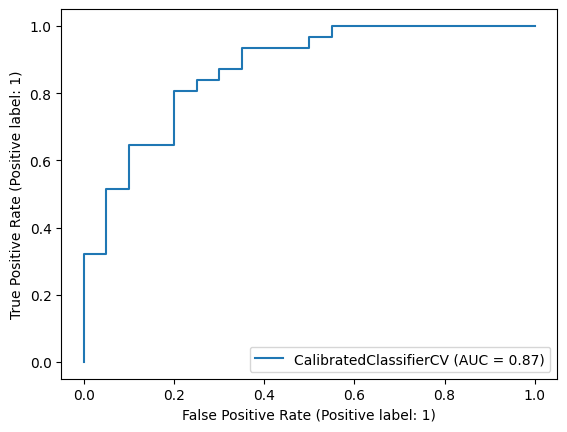

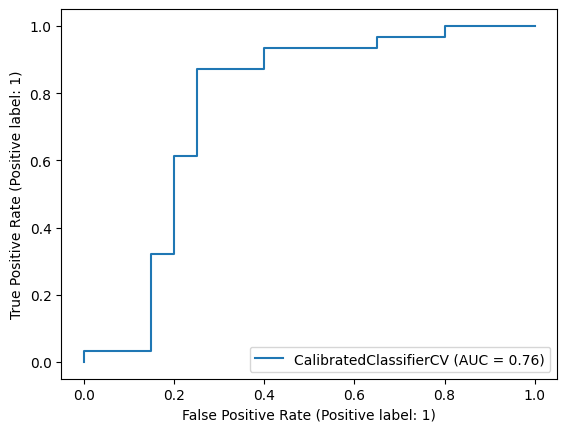

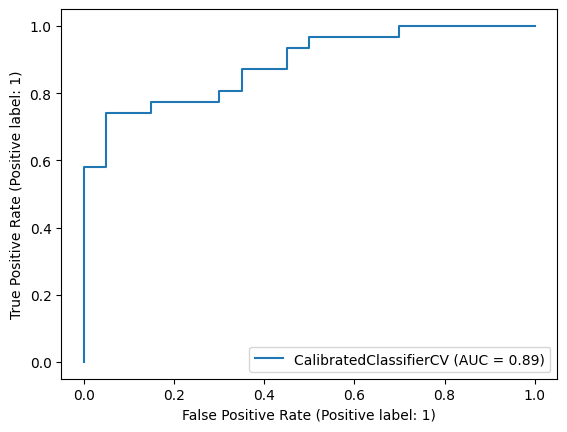

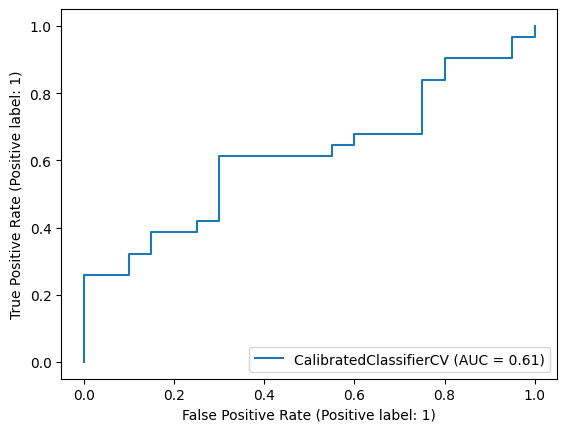

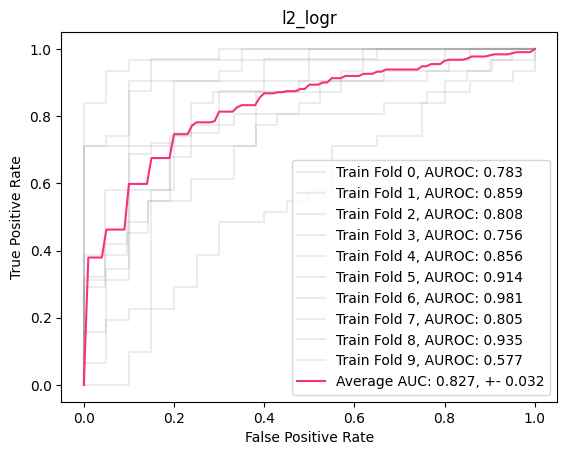

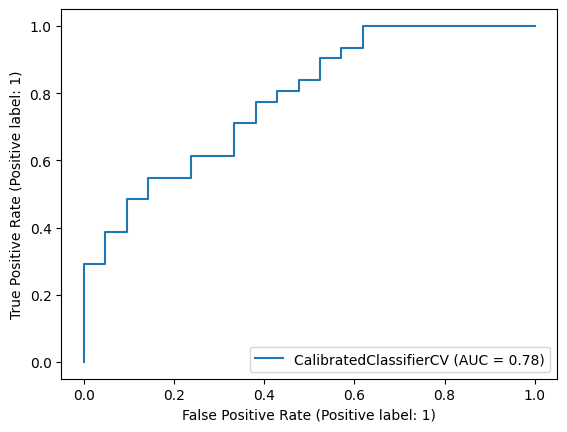

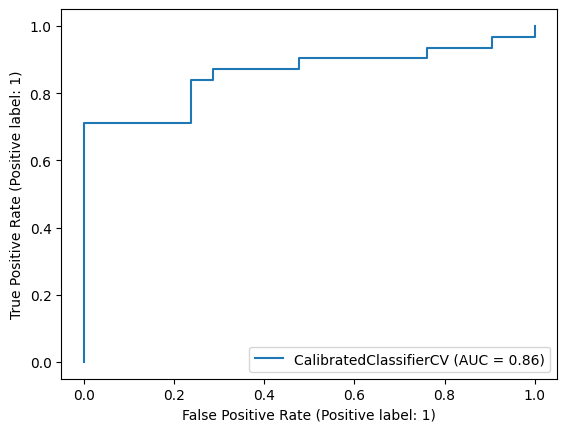

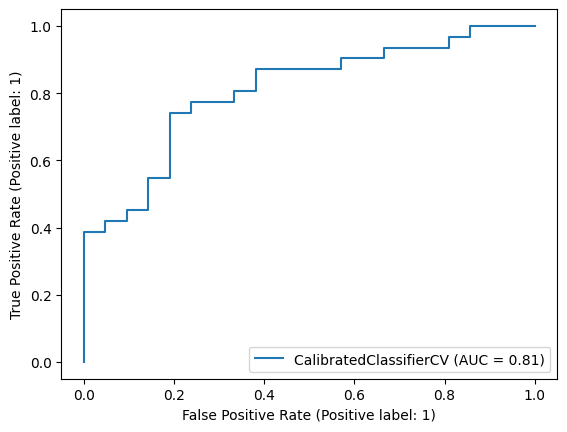

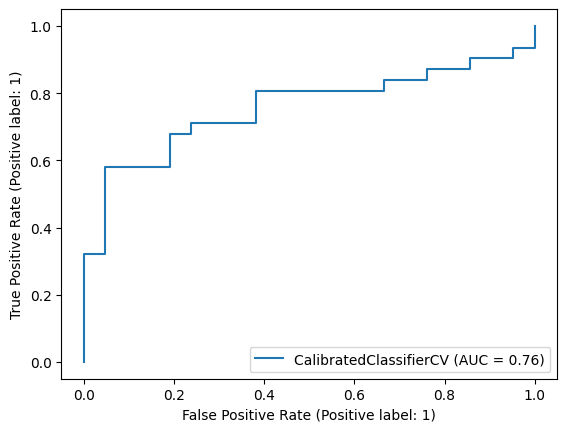

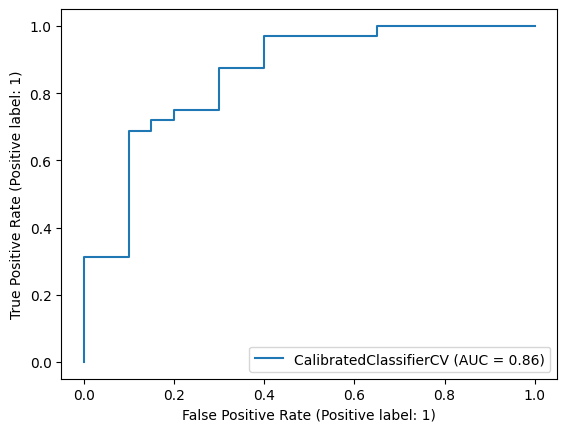

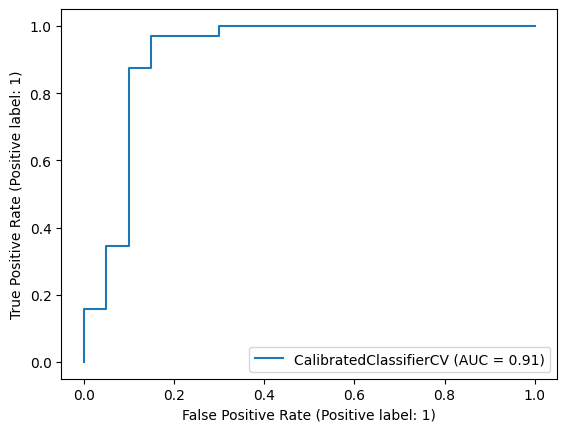

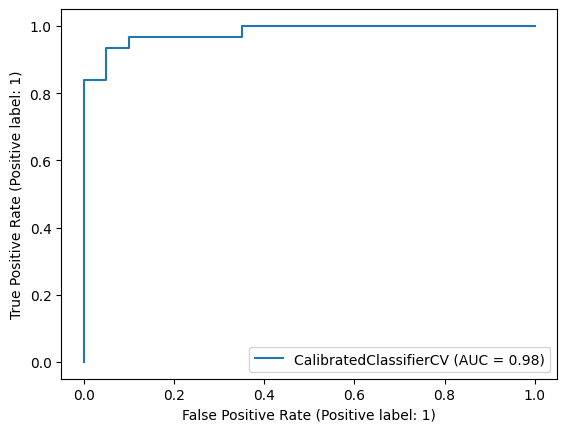

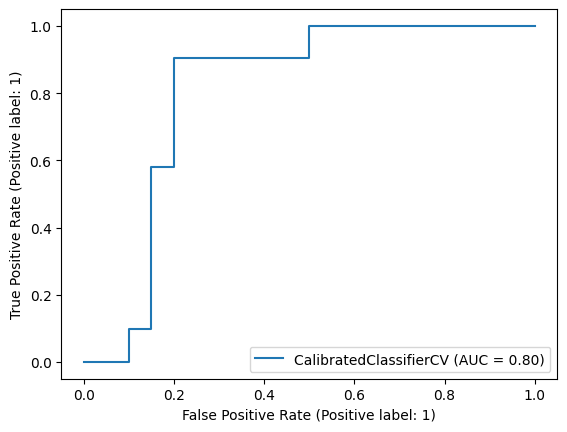

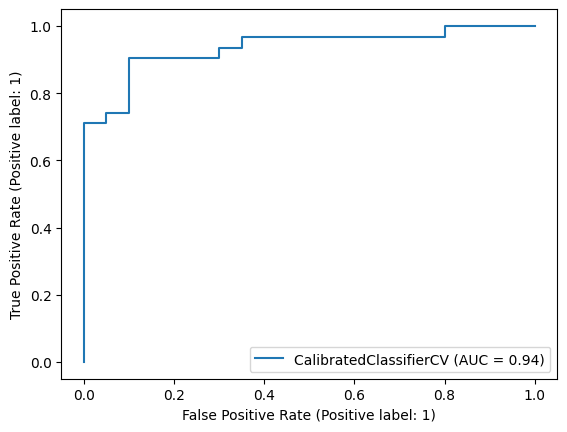

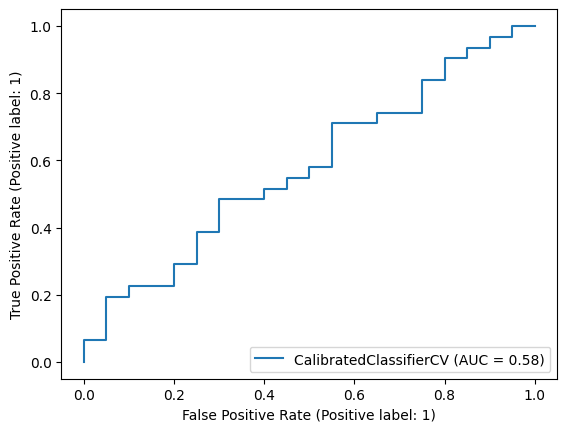

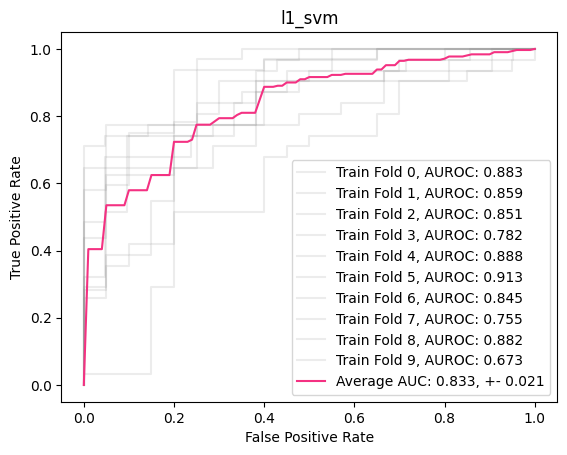

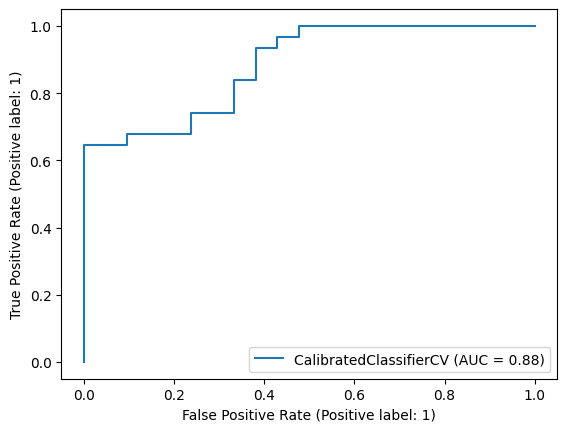

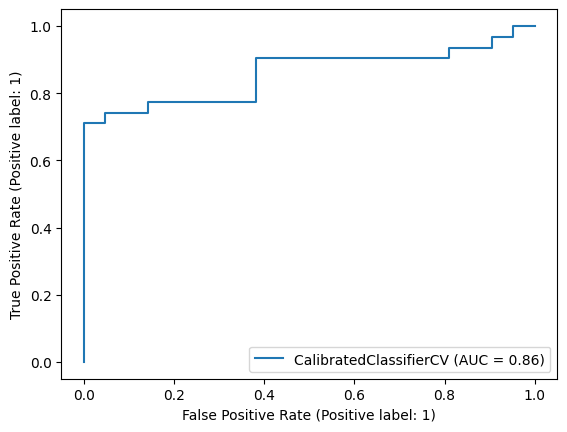

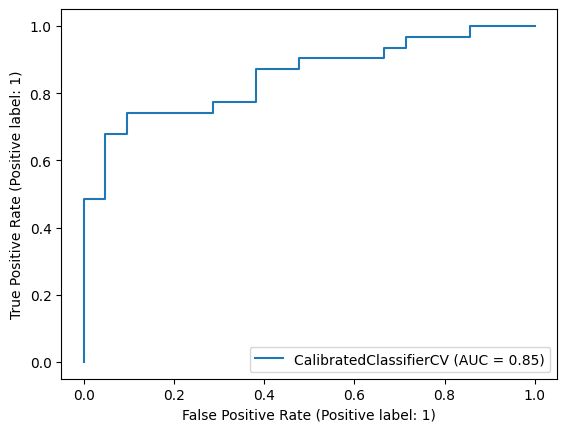

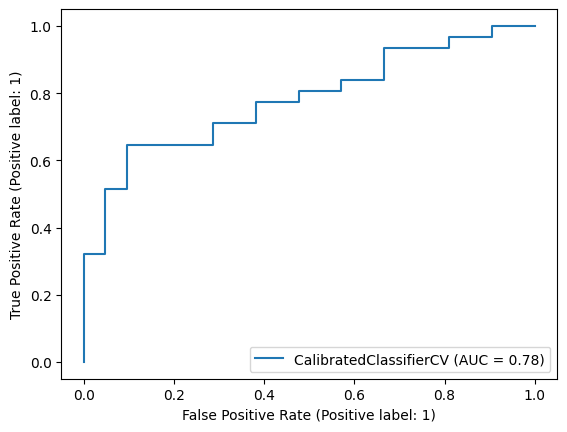

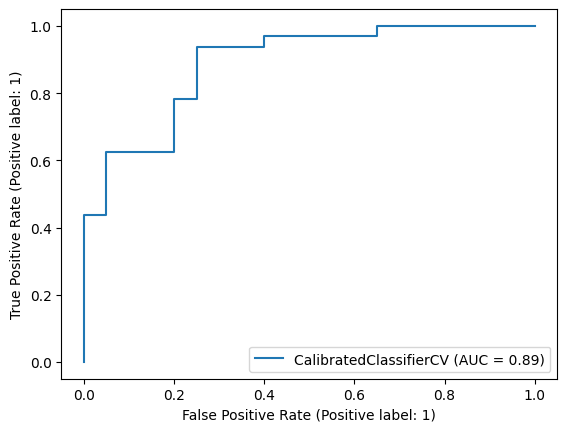

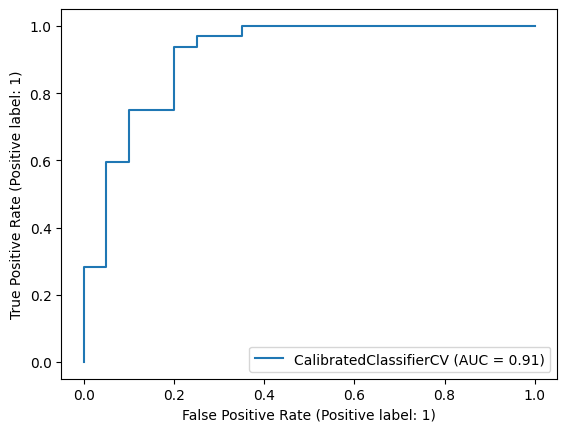

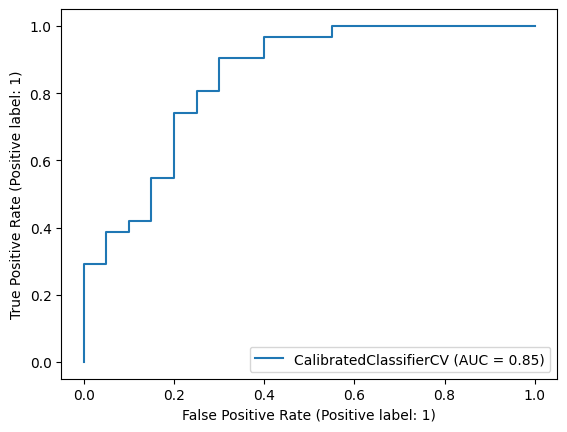

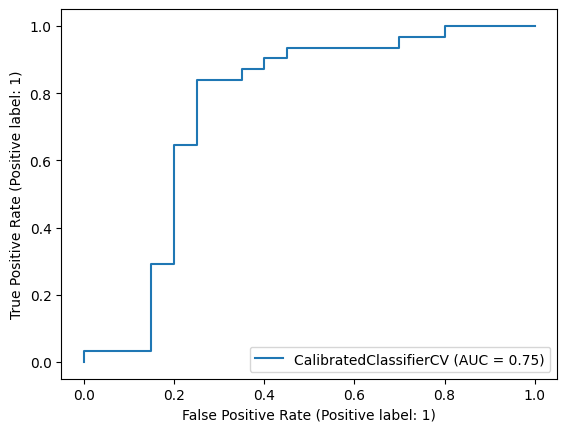

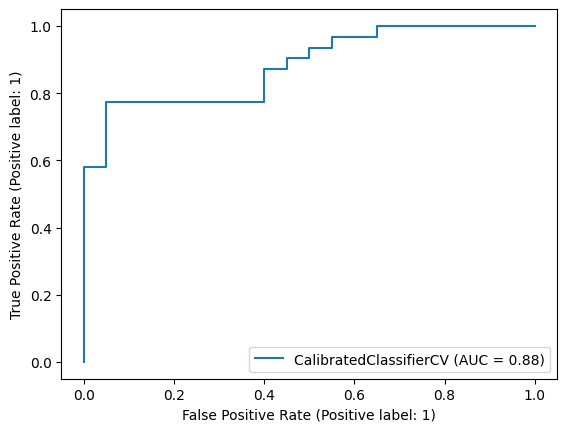

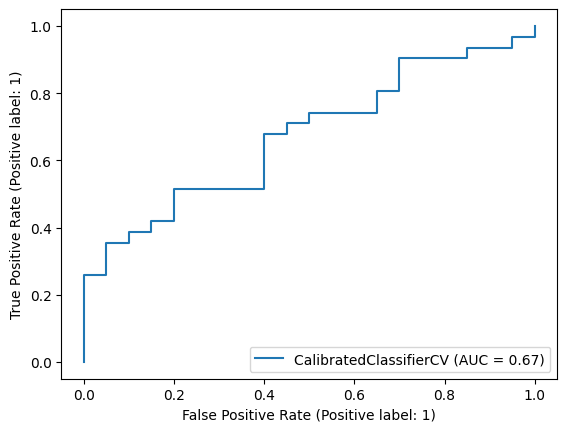

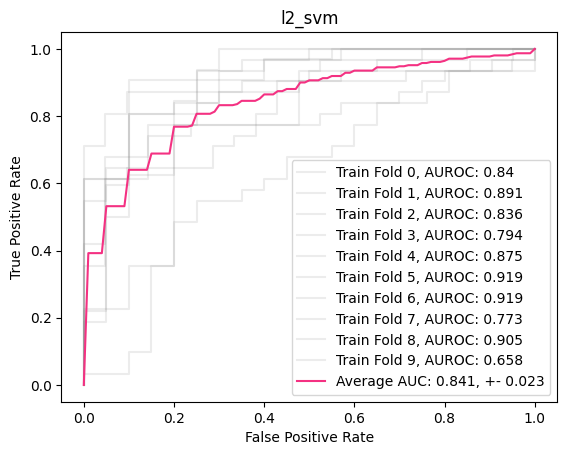

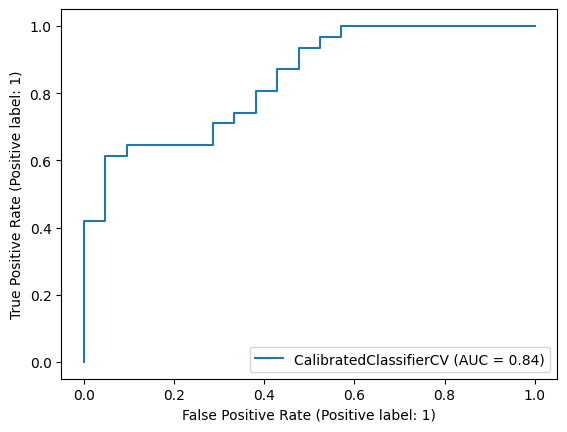

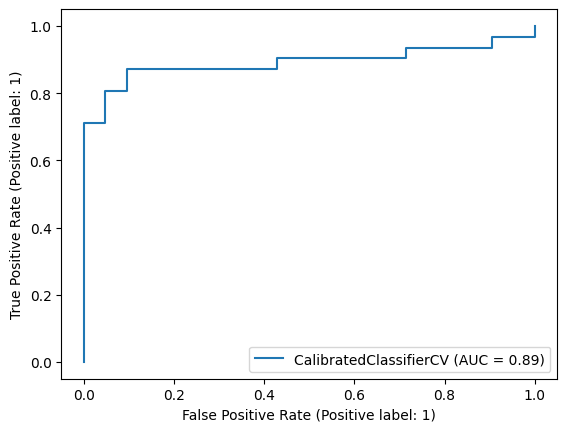

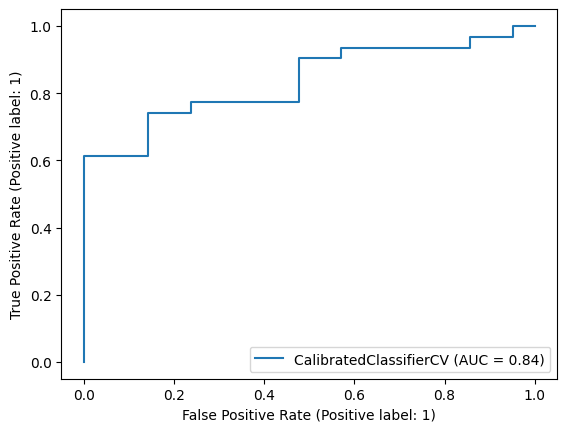

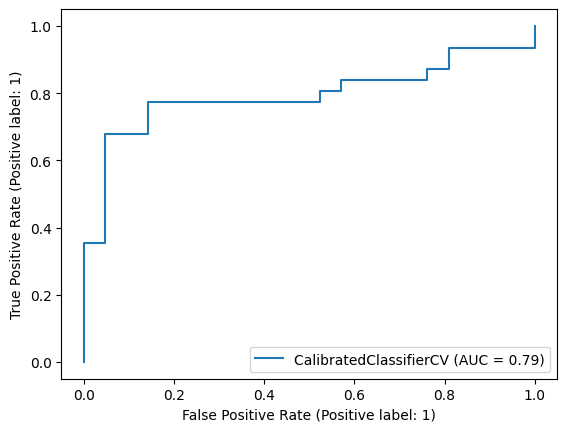

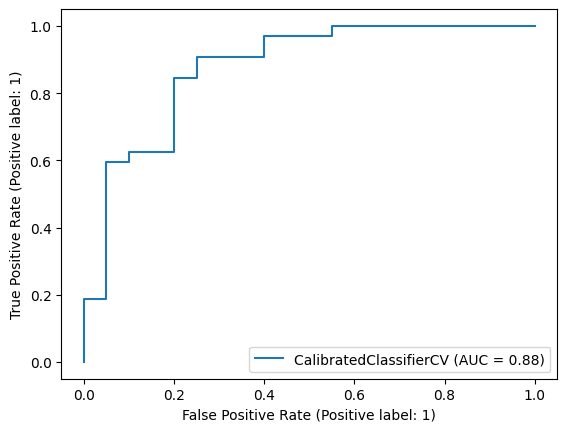

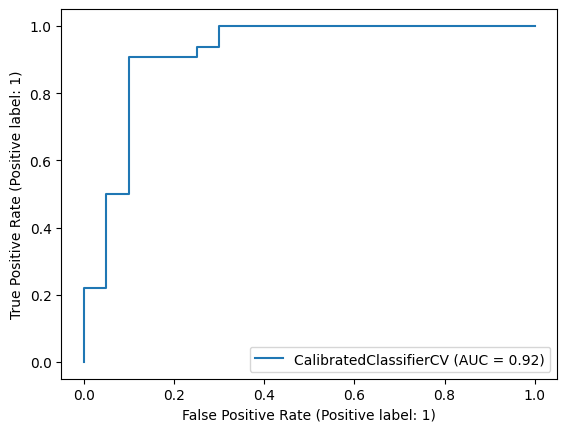

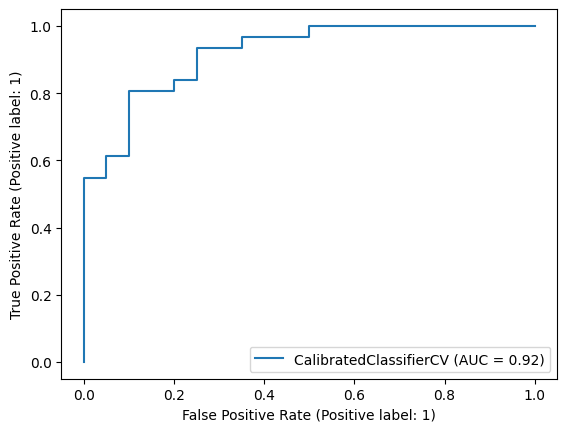

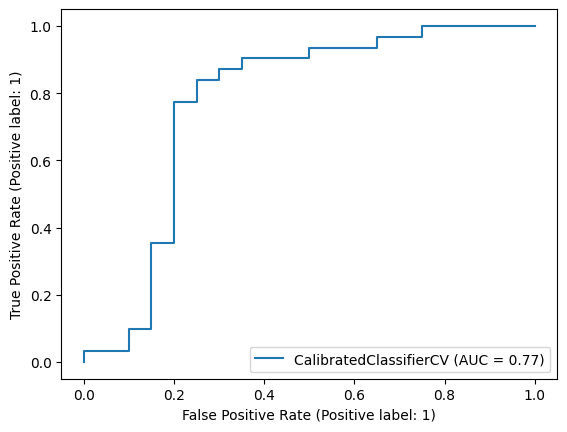

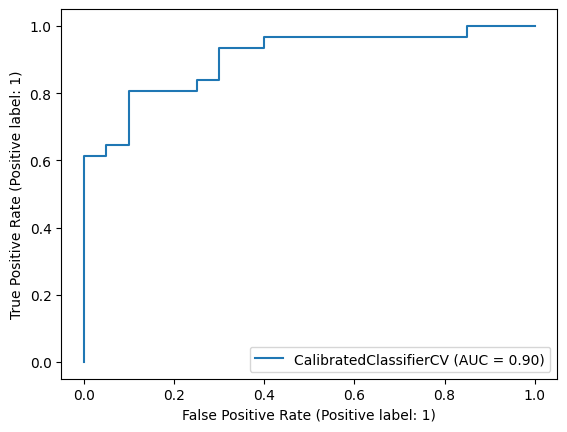

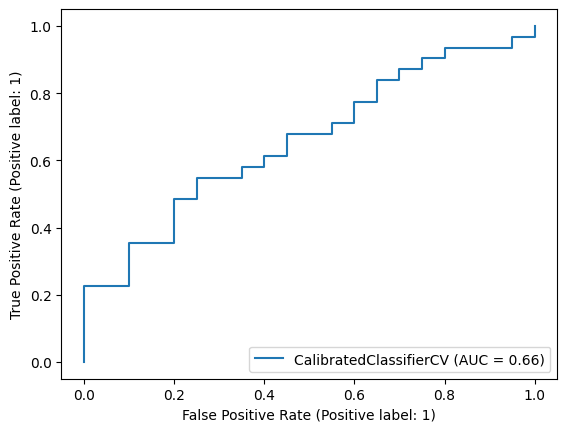

In [625]:
metrics = {
    "accuracy": lambda yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

folds = 10
tot_fig, tot_ax = plt.subplots(2, 2)

train_metrics = {}
for ax_idx, (model_name, model) in enumerate(models.items()):
    skf = uu.StratifiedKFold(n_splits=folds)

    fig, ax = plt.subplots()

    train_metrics[model_name] = {}

    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    for j, (train_index, test_index) in enumerate(skf.split(x_train_select, y_train)):
        train_metrics[model_name][j] = {}
        model_cln = CalibratedClassifierCV(uu.clone(model)) if "svm" in model_name or "forest" else uu.clone(model)

        fold_x_train, fold_x_test = x_train_select[train_index], x_train_select[test_index]
        fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

        model_cln.fit(fold_x_train, fold_y_train)
        test_pred = model_cln.predict(fold_x_test)
        test_pred_probs = model_cln.predict_proba(fold_x_test)[:, 1]
        
        for metric_name, metric_fn in metrics.items():
            train_metrics[model_name][j][metric_name] = metric_fn(test_pred, test_pred_probs, fold_y_test)

        viz_data = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test)
        fpr = viz_data.fpr
        tpr = viz_data.tpr

        train_metrics[model_name][j]["fpr_tpr"] = (fpr, tpr)
        train_metrics[model_name][j]["auc"] = viz_data.roc_auc

        roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        tot_ax[ax_idx%2, ax_idx//2].plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUROC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        train_metrics[model_name][j]["roc_plot"] = roc

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        print("\r", f"Training model {model_name}, fold {j}/{folds}", end="")

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    aucs = [m['auc'] for _, m in train_metrics[model_name].items()]
    mean_auc = np.mean(aucs)
    sd_auc = np.std(aucs)

    ci = 0.95 * sd_auc / np.sqrt(len(aucs))

    ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)  
    tot_ax[ax_idx%2, ax_idx//2].plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    box = tot_ax[ax_idx%2, ax_idx//2].get_position()
    tot_ax[ax_idx%2, ax_idx//2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    tot_ax[ax_idx%2, ax_idx//2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))


    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)
    tot_ax[ax_idx%2, ax_idx//2].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)

    train_metrics[model_name]["roc_curve"] = fig

tot_fig.subplots_adjust(left=0.07, right=1, wspace=3.5, hspace=2)

/var/folders/24/mpw62vn54110sf_ggs3n3ry40000gn/T/ipykernel_80909/2321257801.py:1: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  tot_fig.tight_layout()


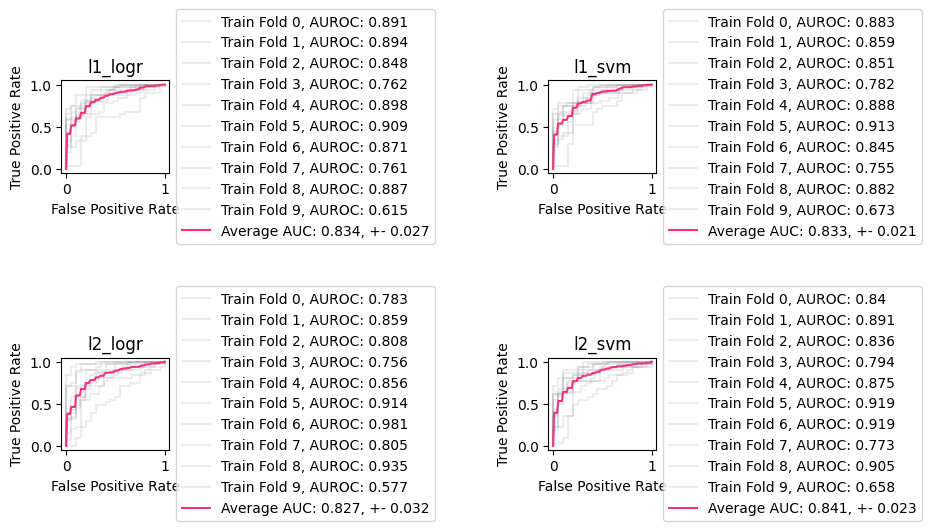

In [626]:
tot_fig.tight_layout()
tot_fig

In [627]:
class_weight = None#{0: 0.6, 1: 0.4}

model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.005, max_iter=1000000, random_state=1, class_weight=class_weight)

models = {"l1_logr":model_l1_logr, "l2_logr": model_l2_logr, 
          "l1_svm":model_l1_svm, "l2_svm": model_l2_svm}

for model_name, model in models.items():
    print("\r", f"fitting {model_name}", end="")
    model.fit(x_train_select, y_train)
print("")
print("finished")

 fitting l2_svmr
finished


In [ ]:
metrics = {
    "accuracy": lambda model, yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda model, yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

def evaluate(model, model_type, metrics=metrics):
    x_pred = model.predict(x_test_select)
    x_proba = model.predict_proba(x_test_select)[:, 1] if model_type != "svm" else model.decision_function(x_test_select)
    return {k: v(model, x_pred, x_proba, y_test) for k, v in metrics.items()}

def pprint_metrics(metrics, name):
    print(f"{name} model test accuracy: {metrics['accuracy']}, test auc: {metrics['auc']}")

metrics_l1_logr = evaluate(model_l1_logr, "logr")
metrics_l2_logr = evaluate(model_l2_logr, "logr")
metrics_l1_svm = evaluate(model_l1_svm, "svm")
metrics_l2_svm = evaluate(model_l2_svm, "svm")

pprint_metrics(metrics_l1_logr, "l1 logistic regression")
pprint_metrics(metrics_l2_logr, "l2 logistic regression")
pprint_metrics(metrics_l1_svm, "l1 support vector mach")
pprint_metrics(metrics_l2_svm, "l2 support vector mach")

In [628]:
# results from PLS boosting model

l1 logistic regression model test accuracy: 0.8, test auc: 0.8918885601577909
l2 logistic regression model test accuracy: 0.8076923076923077, test auc: 0.9134615384615384
l1 support vector mach model test accuracy: 0.8153846153846154, test auc: 0.9080374753451677
l2 support vector mach model test accuracy: 0.8307692307692308, test auc: 0.9151873767258383


In [455]:
#results from PLS model

l1 logistic regression model test accuracy: 0.8, test auc: 0.8920118343195266
l2 logistic regression model test accuracy: 0.7769230769230769, test auc: 0.9006410256410257
l1 support vector mach model test accuracy: 0.7923076923076923, test auc: 0.9011341222879684
l2 support vector mach model test accuracy: 0.823076923076923, test auc: 0.905078895463511


In [464]:
# results from pooled nn model

l1 logistic regression model test accuracy: 0.823076923076923, test auc: 0.8794378698224852
l2 logistic regression model test accuracy: 0.7923076923076923, test auc: 0.8922583826429981
l1 support vector mach model test accuracy: 0.8307692307692308, test auc: 0.8929980276134123
l2 support vector mach model test accuracy: 0.823076923076923, test auc: 0.8954635108481263


In [474]:
# results from nn model

l1 logistic regression model test accuracy: 0.7769230769230769, test auc: 0.8862179487179487
l2 logistic regression model test accuracy: 0.823076923076923, test auc: 0.9013806706114398
l1 support vector mach model test accuracy: 0.8076923076923077, test auc: 0.8925049309664694
l2 support vector mach model test accuracy: 0.8076923076923077, test auc: 0.8925049309664694


In [484]:
# results from linear l1 svm

l1 logistic regression model test accuracy: 0.7615384615384615, test auc: 0.854043392504931
l2 logistic regression model test accuracy: 0.8, test auc: 0.8838757396449703
l1 support vector mach model test accuracy: 0.7307692307692307, test auc: 0.8431952662721894
l2 support vector mach model test accuracy: 0.8, test auc: 0.9013806706114398
